# Import Statements

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

# Opening the File to see the list of parameters

In [2]:
pass5file = '/home/rykore/pass5.1/2.63_3.45e-11_1000000_35_1.0_combined_rec.root'

with uproot.open(pass5file) as file:
    t = file['XCDF']
    t.show() 

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
rec.status           | uint64_t                 | AsDtype('>u8')
rec.version          | uint64_t                 | AsDtype('>u8')
rec.eventID          | uint64_t                 | AsDtype('>u8')
rec.runID            | uint64_t                 | AsDtype('>u8')
rec.timeSliceID      | uint64_t                 | AsDtype('>u8')
rec.trigger_flags    | uint64_t                 | AsDtype('>u8')
rec.event_flags      | uint64_t                 | AsDtype('>u8')
rec.gtc_flags        | uint64_t                 | AsDtype('>u8')
rec.gpsSec           | uint64_t                 | AsDtype('>u8')
rec.gpsNanosec       | uint64_t                 | AsDtype('>u8')
rec.nChTot           | uint64_t                 | AsDtype('>u8')
rec.nChAvail         | uint64_t                 | AsDtype('>u8')
rec.nHitTot          | uint64_t                 | AsDtype(

# Redefining variables based on what is needed

In [3]:
dset = dict()

with uproot.open(pass5file) as file:
    t = file['XCDF']
    dset["zenithAngle"] = t["rec.zenithAngle"].array(library="np")
    dset["azimuthAngle"] = t["rec.azimuthAngle"].array(library="np")
    dset["nHit"] = t["rec.nHit"].array(library="np")
    dset["protonlheEnergy"] = t["rec.protonlheEnergy"].array(library="np")
    dset["PINC"] = t["rec.PINC"].array(library="np")
    dset["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np") 
    dset["angleFitStatus"] = t["rec.angleFitStatus"].array(library="np")
    dset["coreFitStatus"] = t["rec.coreFitStatus"].array(library="np")
    # fit status of the reconstruction, 0 meaning successfull and != 0 means unsuccessful
    dset["cuts"] = np.logical_and(dset["angleFitStatus"] == 0, dset["coreFitStatus"] == 0)
    dset["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
    dset["weights"] = t["sweets.IWgt"].array(library="np")
    # corsikaParticleId != 1 - Excludes gamma rays
    dset["cuts"] = np.logical_and(dset["cuts"] , dset["corsikaParticleId"]!=1 )
    dset["logEnergy"] = t["mc.logEnergy"].array(library="np")

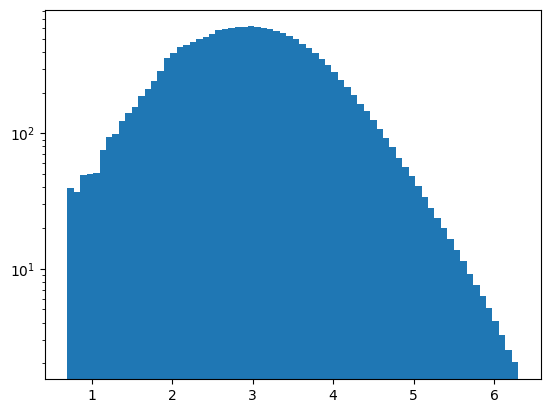

In [4]:
# adding weights - gives the simulated data a weight to make it closer to the actual data
plt.hist(dset["logEnergy"][dset["cuts"]], bins = 70, log=True, weights = dset["weights"][dset["cuts"]])
plt.show()

In [21]:
initial_cuts = dset["cuts"]
zenith_angle = dset["zenithAngle"][initial_cuts]
log_E = dset["logEnergy"][initial_cuts]
weights = dset["weights"][initial_cuts]

In [6]:
print(len(log_E))
print(len(weights))

8438332
8438332


# Cutting and binning the Energy

In [7]:
cut1 = np.logical_and(log_E >= np.log(1),log_E < np.log(10))
cut2 = np.logical_and(log_E >= np.log(10),log_E < np.log(30))
cut3 = np.logical_and(log_E >= np.log(30),log_E < np.log(50))
cut4 = np.logical_and(log_E >= np.log(50),log_E <= np.log(100))

In [8]:
energy_cut1 = log_E[cut1]
energy_cut2 = log_E[cut2]
energy_cut3 = log_E[cut3]
energy_cut4 = log_E[cut4]

energies = [energy_cut1, energy_cut2, energy_cut3, energy_cut4]

In [9]:
weights_cut1 = weights[cut1]
weights_cut2 = weights[cut2]
weights_cut3 = weights[cut3]
weights_cut4 = weights[cut4]

weights_array = [weights_cut1, weights_cut2, weights_cut3, weights_cut4]

In [22]:
zenith_cut1 = zenith_angle[cut1]
zenith_cut2 = zenith_angle[cut2]
zenith_cut3 = zenith_angle[cut3]
zenith_cut4 = zenith_angle[cut4]

zenith_array = [zenith_cut1, zenith_cut2, zenith_cut3, zenith_cut4]

# Weighted Quantile function
#### input:
values = log_E  \
quantiles = \[0.341, 0.841\] (array of what quantiles of the data you need) \
sample_weight = weights (apply cuts on weights as well so that the dimensions of both the arrays remain the same) \
values_sorted (if False, will sort the returned array)
#### output:
an interpolated array having the same dimensions as the quantiles array from the input that has the weighted values in the data at those specified quantiles

In [11]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ 
    Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!

    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.

    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

# Binning the zenith angle

In [27]:
# 180 degrees divided into 18 bins with each bin being 10 degrees
deltaz = np.radians(10)
zbins = np.arange(min(zenith_angle),max(zenith_angle), deltaz)
print(zbins)

[1.00000000e-04 1.74632925e-01 3.49165850e-01 5.23698776e-01
 6.98231701e-01 8.72764626e-01 1.04729755e+00 1.22183048e+00
 1.39636340e+00]


In [28]:
print(len(zenith_cut1))

239446


In [46]:
yerr = weighted_quantile(energy_cut1, 0.159, sample_weight = weights_cut1)
print(yerr)

1.427


# Plotting the average energy vs zenith angle

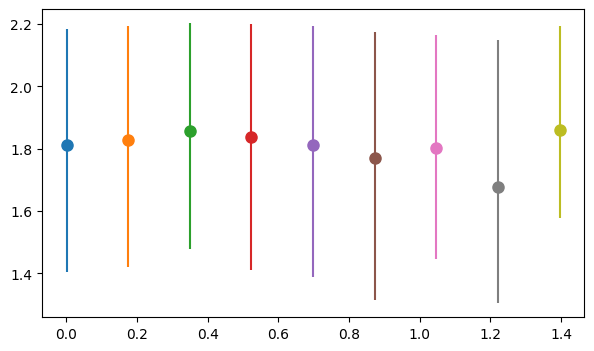

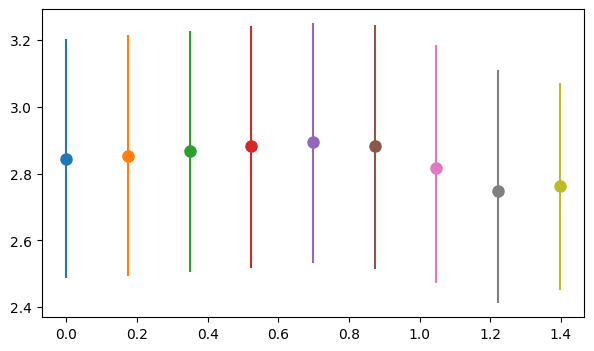

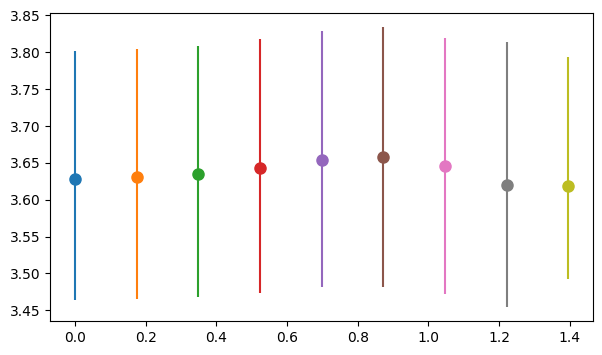

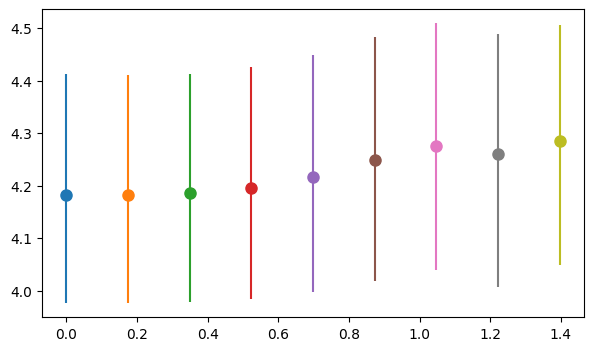

In [51]:
for energy, weight, zenith in zip(energies, weights_array, zenith_array):
    
    fig, ax = plt.subplots(figsize=(7, 4))
    
    for z in zbins:
        zmin = z
        zmax = z + deltaz
        zcut = np.logical_and(zenith >= zmin, zenith <= zmax)
        avg_energy = np.average(energy[zcut], weights = weight[zcut])
        
        upper_quantile = weighted_quantile(energy[zcut], 0.841 , sample_weight = weight[zcut])
        lower_quantile = weighted_quantile(energy[zcut], 0.159 , sample_weight = weight[zcut])

        err_upper = upper_quantile - avg_energy
        err_lower = avg_energy - lower_quantile
        
        ax.errorbar(z, avg_energy, yerr = [[err_lower], [err_upper]] , fmt = 'o', markersize = 8)
        
    plt.show()

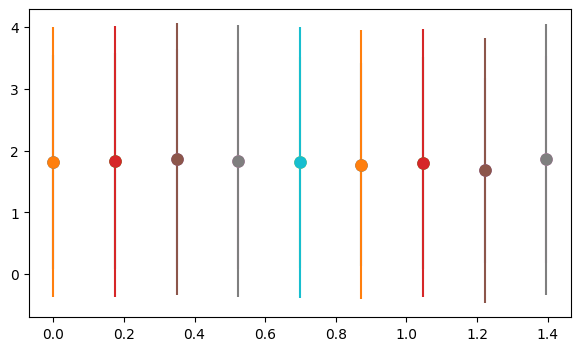

In [52]:
# sample for one
fig, ax = plt.subplots(figsize=(7, 4))

for z in zbins:
    zmin = z
    zmax = z + deltaz
    zcut = np.logical_and(zenith_cut1 >= zmin, zenith_cut1 <= zmax)
    avg_energy = np.average(energy_cut1[zcut], weights = weights_cut1[zcut])
    yerr = weighted_quantile(energy_cut1[zcut], [0.341, 0.841], sample_weight = weights_cut1[zcut])
    ax.errorbar(z, avg_energy, yerr = yerr[0],  marker='o', markersize = 8)
    ax.errorbar(z, avg_energy, yerr = yerr[1],  marker='o', markersize = 8)

plt.show()